# Contextualized Token Embeddings

In [1]:
!pip install -r requirements.txt

  Using cached scipy-1.10.1-cp39-cp39-win_amd64.whl (42.5 MB)
  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
  Using cached pandas-2.2.2-cp39-cp39-win_amd64.whl (11.6 MB)
  Using cached scikit_learn-1.5.0-cp39-cp39-win_amd64.whl (11.0 MB)
  Using cached matplotlib-3.9.0-cp39-cp39-win_amd64.whl (7.9 MB)
  Using cached gensim-4.3.2-cp39-cp39-win_amd64.whl (24.0 MB)
  Using cached torch-2.3.0-cp39-cp39-win_amd64.whl (159.7 MB)
  Using cached pytorch_transformers-1.2.0-py3-none-any.whl (176 kB)
  Using cached sentence_transformers-3.0.0-py3-none-any.whl (224 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached botocore-1.34.116-py3-none-any.whl (12.3 MB)
  Using cached boto3-1.34.116-py3-none-any.whl (139 kB)
  Using cached datasets-2.19.1-py3-none-any.whl (542 kB)
  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tzdata-2024.2-py2.py3-none-a

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [38 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\pickle5
  copying pickle5\pickle.py -> build\lib.win-amd64-cpython-39\pickle5
  copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-39\pickle5
  copying pickle5\__init__.py -> build\lib.win-amd64-cpython-39\pickle5
  creating build\lib.win-amd64-cpython-39\pickle5\test
  copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-39\pickle5\test
  copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-39\pickle5\test
  copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-39\pickle5\test
  copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-39\pickle5\test
  running build_ext
  building 'pickle5._pickle' extension
  creating build\temp

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

## GloVe word Embeddings

In [4]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100')

In [5]:
word_vectors['prince'].shape

(100,)

In [6]:
# Words to visualize
words = ["king", "princess", "monarch", "throne", "crown", 
         "mountain", "ocean", "tv", "rainbow", "cloud", "queen"]

# Get word vectors
vectors = np.array([word_vectors[word] for word in words])

In [7]:
# Reduce dimensions to 2 using PCA
pca = PCA(n_components = 2)
vectors_pca = pca.fit_transform(vectors)

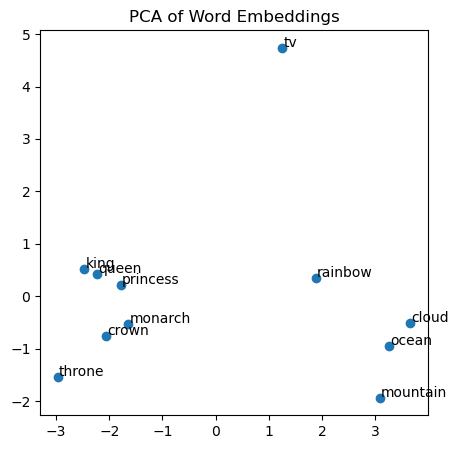

In [8]:
# Plotting
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0] + .02, vectors_pca[i, 1] + .02))
axes.set_title('PCA of Word Embeddings')
plt.show()

## Word2Vec algebra

In [9]:
result = word_vectors.most_similar(positive = ['king','woman'],
                                  negative = ['man'], topn=1)

print(f"""
    The word closest to 'king' - 'man' + 'woman' is: '{result[0][0]}'
    with a similarity score of {result[0][1]}""")


    The word closest to 'king' - 'man' + 'woman' is: 'queen'
    with a similarity score of 0.7698540687561035


## GloVe vs BERT: words in context

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors = 'pt')
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_states[0, word_index + 1, :] # +1 to account for [CLS] token
    return word_embedding

In [11]:
sentence1 = "The bat flew out of the cave at night."
sentence2 = "He swung the bat and hit a home run."

word = "bat"
bert_embedding1 = get_bert_embeddings(sentence1,word).detach().numpy()
bert_embedding2 = get_bert_embeddings(sentence2,word).detach().numpy()
word_embedding = word_vectors[word]

In [12]:
print("BERT Embedding for 'bat' in sentence 1:", bert_embedding1[:5])
print("BERT Embedding for 'bat' in sentence 2:", bert_embedding2[:5])
print("GloVe Embedding for 'bat':", word_embedding[:5])

bert_similarity = cosine_similarity([bert_embedding1], [bert_embedding2])[0][0]
word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print()
print(f"Cosine Similarity between BERT embeddings in different contexts: {bert_similarity}")
print(f"Cosine Similarity between GloVe embeddings: {word_embedding_similarity}")


BERT Embedding for 'bat' in sentence 1: [ 0.41316164 -0.12908185 -0.44865698 -0.4049265  -0.15305701]
BERT Embedding for 'bat' in sentence 2: [ 0.6406692  -0.31121525 -0.44089818 -0.16551183 -0.2005609 ]
GloVe Embedding for 'bat': [-0.47601  0.81705  0.11151 -0.22687 -0.80672]

Cosine Similarity between BERT embeddings in different contexts: 0.4599575400352478
Cosine Similarity between GloVe embeddings: 1.0


## Cross Encoder

In [13]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512, 
                     default_activation_function=torch.nn.Sigmoid())

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [14]:
question = 'Where is the capital of France'

#Define sentences to compare
answers = [
    "Paris is the capital of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain."    
]

In [15]:
scores = model.predict([(question, answers[0]), (question, answers[1]),
                        (question, answers[2])])
print(scores)
most_relevant_idx = torch.argmax(torch.tensor(scores)).item()
print(f"The most relevant passage is: {answers[most_relevant_idx]}")

[0.9997274  0.03096339 0.02810255]
The most relevant passage is: Paris is the capital of France.
